# Lotka Volterra UPINN

In [2]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

# This problem is so small that the GPU overhead is slower than using the CPU
device = 'cpu'

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [3]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 10 # Number of data points

time_int = [0, 10]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LotkaVolterraData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points, noise_level=0.0)

td = data.td
Xd = data.Xd

In [4]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [5]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [6]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']
        self.log = dict()

    def forward(self, z, U):

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        # self.log.setdefault('alpha', []).append(self.alpha.item())
        # self.log.setdefault('delta', []).append(self.delta.item())

        return torch.stack([
            (dUdt[:, 0] - self.alpha*U[:, 0]), # + beta*U[:, 0]*U[:, 1],
            (dUdt[:, 1] + self.delta*U[:, 1]) # - gamma*U[:, 0]*U[:, 1] # <-- Estimate this
        ], dim=-1)


params = dict(
    alpha=alpha,
    # alpha=torch.nn.Parameter(torch.tensor(1.0)),
    beta=beta,
    # delta=torch.nn.Parameter(torch.tensor(1.0)),
    delta=delta,
    gamma=gamma
)

N = SparseLV(params)

### Problem specific UPINN functions

In [7]:
psi = torch.nn.Parameter(torch.tensor(1.0))

In [8]:
class LV_UPINN(UPINN):

    # def set_psi(self):
    #     self.phi = torch.nn.Parameter(torch.tensor(1.0))

    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()
    #     lambdas = SoftAdapt(**self.softadapt_kwargs)(torch.tensor([bc_loss, data_loss, pde_loss]))
    #     loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss

    #     return loss, bc_loss, data_loss, pde_loss

    def F_input(self, z, U):
        return U

    def score(self):
        u_pred = self.u(data.t_full)

        L2_rel_error = torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
        return L2_rel_error.item()

        # return torch.nn.MSELoss()(u_pred, data.X_full)
    
    def score_residual(self):
        u_pred = self.u(data.t_full)
        F_pred = self.F(self.F_input(data.t_full, u_pred))

        # self.shared_res = True
        # if self.shared_res:
        #     F_pred = torch.cat((F_pred, self.psi*F_pred), dim=1)
               
        F_exp_1 = beta*u_pred[:, 0]*u_pred[:, 1]
        F_exp_2 = -gamma*u_pred[:, 0]*u_pred[:, 1]
        F_exp = torch.stack([F_exp_1, F_exp_2], dim=-1)

        L2_rel_error = torch.sqrt(torch.mean((F_pred - F_exp)**2) / torch.mean(F_exp**2))
        return L2_rel_error.item()

    
    def pde_loss(self):
        # self.log.setdefault('psi', []).append(self.psi.item())
        if self.collocation_points is not None:
            U_c = self.u(self.collocation_points)
            res = self.F(self.F_input(self.collocation_points, U_c))

            # self.shared_res = True
            # if self.shared_res:
            #     res = torch.cat((res, self.psi*res), dim=1)

            known = self.N(self.collocation_points, U_c)
            pde_loss = torch.nn.MSELoss()(known, -res) if self.collocation_points.shape[0] > 0 else torch.tensor(0.0)
        else: pde_loss = torch.tensor(0.0)
        return pde_loss
    
    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        res_loss = torch.mean(torch.abs(self.F(self.F_input(self.collocation_points, self.u(self.collocation_points)))))
        # self.log.setdefault('res_loss', []).append(res_loss.item())

        U_c = self.u(self.collocation_points)
        res = self.F(self.F_input(self.collocation_points, U_c))
        # Correllation loss
        U_c_norm = U_c / (torch.norm(U_c, dim=0)+1e-8)
        res_norm = res / (torch.norm(res, dim=0)+1e-8)

        temp = torch.mean(torch.diag(U_c_norm.T @ res_norm)**2)

        loss = self.lambdas[0]*bc_loss + self.lambdas[1]*data_loss + self.lambdas[2]*pde_loss + 1e-3*temp

        return loss, bc_loss, data_loss, pde_loss


    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(self.collocation_points)
            F_pred = self.F(self.F_input(t_plot, u_pred))

            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            fig, ax = plt.subplots(2, 1, figsize=(8, 6))
            plt.subplot(2, 1, 1)
            plt.plot(td, Xd[:, 0], 'ro')
            plt.plot(t_plot, x_pred, 'r', label='Pred. Predator')
            plt.plot(t_plot, x_true, 'r--', label='True Predator')
            plt.plot(td, Xd[:, 1], 'bo')
            plt.plot(t_plot, y_pred, 'b', label='Pred. Prey')
            plt.plot(t_plot, y_true, 'b--', label='True Prey')
            plt.scatter(td, Xd[:, 0], color='r', s=1)
            plt.scatter(td, Xd[:, 1], color='b', s=1)
            plt.xlabel('t')
            plt.legend()
            plt.xlim([time_int[0], time_int[1]])
            plt.ylim([0, 2])
            
            plt.subplot(2, 1, 2)
            plt.plot(t_plot, F_pred[:, 0], 'r', label='Pred. Predator residual')
            plt.plot(t_plot, beta*x_true*y_true, 'r--', label='True Predator residual')
            plt.plot(t_plot, F_pred[:, 1], 'b', label='Pred. Prey residual')
            plt.plot(t_plot, -gamma*x_true*y_true, 'b--', label='True Prey residual')
            plt.xlabel('t')
            plt.legend()
            plt.xlim([time_int[0], time_int[1]])
            plt.ylim([-1.5, 2])
            plt.tight_layout()
            plt.legend( loc='upper center', bbox_to_anchor=(0.3, 1.0))

            if save is not None:
                plt.savefig('gfx/'+save+'.pdf', format='pdf', bbox_inches='tight')

            plt.show()


### Setup UPINN

In [9]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)
F = FNN(
    dims=[2, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

# F = KAN([2, 2, 2], grid=5)

In [10]:
model = LV_UPINN(u, N, F, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)
# model.set_psi()
# F.phi = torch.nn.Parameter(torch.tensor(1.0))

[Info]: Initializing UPINN model


### Train

In [48]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, factor=0.8, patience=1000, threshold=1e-3)
model.scheduler = scheduler
model.optimizer = adamw

In [ ]:
model.train_loop(5000)

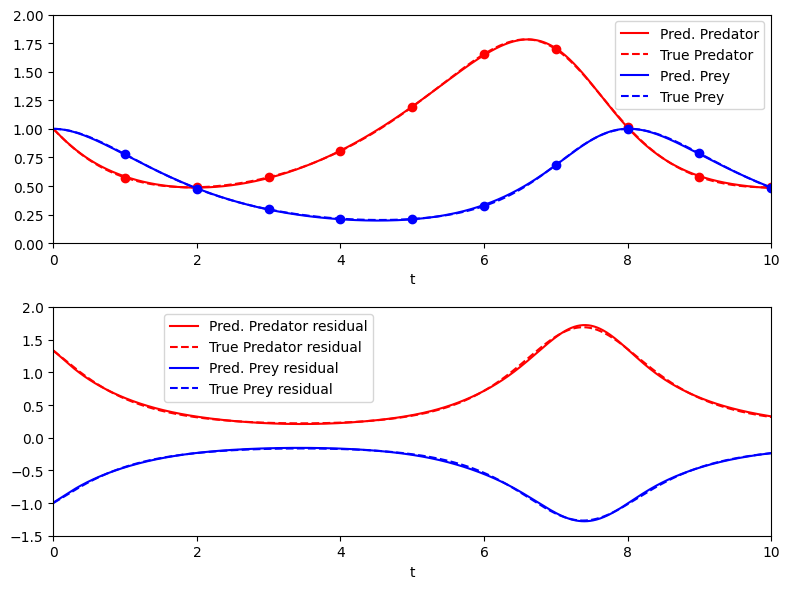

In [15]:
model.plot()

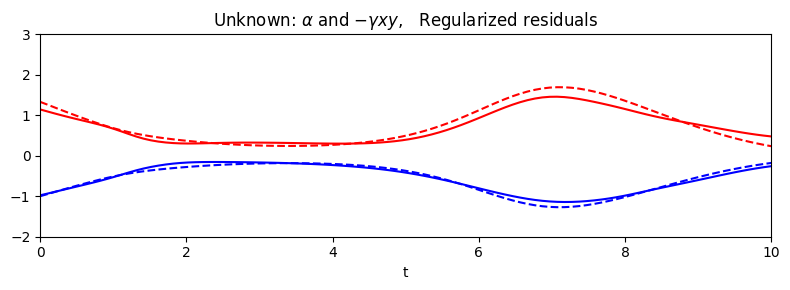

In [270]:
model.to('cpu')
t = torch.linspace(0, time_int[1], 100).reshape(-1, 1)
u = model.u(t).detach()

data_full = LotkaVolterraData(X0, alpha, beta, gamma, delta, [0, 20])

plt.figure(figsize=(8, 3))

# plt.subplot(2, 1, 1)

# plt.plot(t.detach().numpy(), u[:, 0].detach().numpy(), 'r', label='Predicted Predator')
# plt.plot(td[1::2], Xd[1::2, 0], 'ro', markersize=4)
# plt.plot(data_full.t_full, data_full.X_full[:, 0], 'r--', label='True Predator')
# plt.plot(t.detach().numpy(), u[:, 1].detach().numpy(), 'b', label='Predicted Prey')
# plt.plot(td[1::2], Xd[1::2, 1], 'bo', markersize=4)
# plt.plot(data_full.t_full, data_full.X_full[:, 1], 'b--', label='True Prey')
# plt.xlim([0, 10])
# plt.xlabel('t')
# plt.ylim([0, 2])
# plt.legend()

# plt.subplot(2, 1, 2)

F_pred = model.F(model.F_input(t, u)).detach()
plt.plot(t.detach().numpy(), F_pred[:, 0].detach().numpy(), 'r', label='Predicted Predator residual')
plt.plot(t.detach().numpy(), beta*u[:, 0]*u[:, 1], 'r--', label='True Predator residual')
plt.plot(t.detach().numpy(), F_pred[:, 1].detach().numpy(), 'b', label='Predicted Prey residual')
plt.plot(t.detach().numpy(), -gamma*u[:, 0]*u[:, 1], 'b--', label='True Prey residual')
plt.xlabel('t')
plt.xlim([0, 10])
plt.ylim([-2, 3])
# Move the legend to the right
# plt.legend(loc='upper left')
plt.title(r'Unknown: $\alpha$ and $-\gamma x y$,   Regularized residuals')

plt.tight_layout()

# plt.savefig('gfx/lv_baseline_unknown_alpha_gammaxy_reg.pdf', format='pdf', bbox_inches='tight')

plt.show()

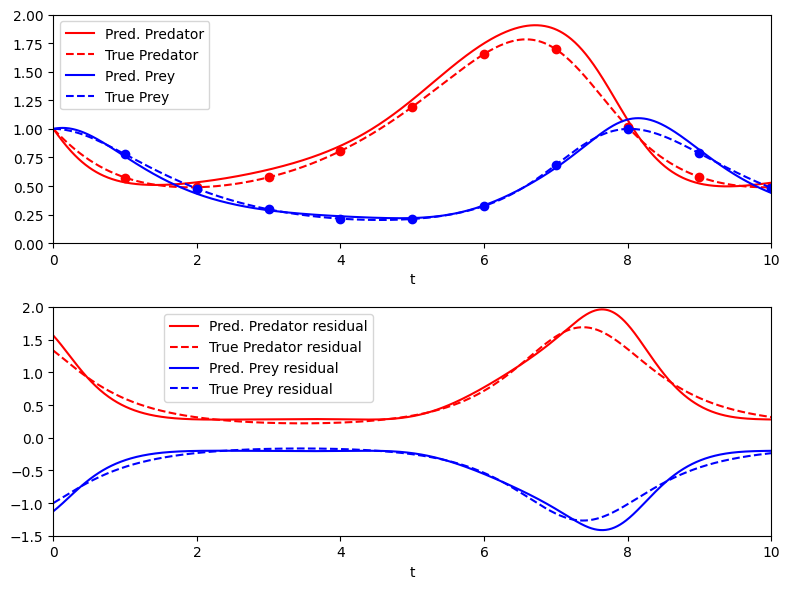

In [336]:
model.plot('lv_data5_noise0100_shared')

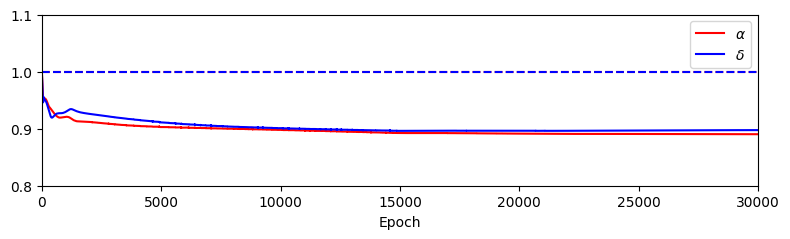

In [ ]:
plt.figure(figsize=(8, 2.5))
plt.plot(N.log['alpha'], 'r', label=r'$\alpha$')
plt.plot([0, 30000], [1, 1], 'r--')
plt.plot(N.log['delta'], 'b', label=r'$\delta$')
plt.plot([0, 30000], [1, 1], 'b--')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 1.1])
plt.xlim([0, 30000])
plt.tight_layout()
# plt.savefig('gfx/lv_baseline_unknown_params_alpha_delta.pdf', format='pdf', bbox_inches='tight')
plt.show()